In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
path = '/home/james/Documents/DS3000/DS_Project/t_data.csv'
data = pd.read_csv(path)
data.drop(columns=['Unnamed: 0.5', 'Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
data.head()

,Sno,X,State,conversation_id,retweet_count,reply_count,like_count,quote_count,Buzz,id,...,we.1,they,insight,cause,discrep,certitude,Positive,Negative,Total_Sentiment,cluster
0,1,1,Assam,S1438213588544409600,0,1,1,0,3,S1438213588544409600,...,0.0,0.0,3.23,0.0,0.00,0.0,1,-2,1,53
1,2,2,Assam,S1438437895270846464,0,1,1,0,3,S1438437895270846464,...,0.0,0.0,0.00,0.0,0.00,0.0,1,-1,0,53
2,3,3,Assam,S1439558164936941574,0,1,1,0,3,S1439558164936941574,...,0.0,0.0,0.00,0.0,0.00,0.0,1,-2,1,47
3,4,4,Assam,S1439920409801945089,0,1,3,0,5,S1439920409801945089,...,0.0,0.0,0.00,0.0,2.08,0.0,1,-1,0,64
4,5,5,Assam,S1440221445011898371,0,1,1,0,3,S1440221445011898371,...,0.0,0.0,5.71,0.0,0.00,0.0,1,-1,0,6


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import sklearn

# Check scikit-learn version
from packaging import version
SKLEARN_VERSION = sklearn.__version__

def preprocess_data(df, features, target_column, ignore_zero_targets=False):
    if ignore_zero_targets:
        df = df[df[target_column] != 0]

    df = df[features + [target_column]].copy()

    # Handle date features
    df['Date1'] = pd.to_datetime(df['Date1'], errors='coerce')
    df['Year'] = df['Date1'].dt.year
    df['Month'] = df['Date1'].dt.month
    df['DayOfWeek'] = df['Date1'].dt.dayofweek
    df['DayOfMonth'] = df['Date1'].dt.day

    # Handle time features
    df['ParsedTime'] = pd.to_datetime(df['Time'], errors='coerce')
    df['Hour'] = df['ParsedTime'].dt.hour.fillna(0)
    df['Minute'] = df['ParsedTime'].dt.minute.fillna(0)
    df.drop(columns=['ParsedTime'], inplace=True)

    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != target_column]

    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

    # Handle OneHotEncoder compatibility
    if version.parse(SKLEARN_VERSION) >= version.parse("1.2"):
        onehot_params = {'handle_unknown': 'ignore', 'sparse_output': False}
    else:
        onehot_params = {'handle_unknown': 'ignore', 'sparse': False}

    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(**onehot_params))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    target = df[target_column]
    df = df.drop(columns=[target_column])
    df_preprocessed = preprocessor.fit_transform(df)

    # Get feature names after OneHotEncoding
    if version.parse(SKLEARN_VERSION) >= version.parse("1.0"):
        onehot_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
    else:
        onehot_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names(categorical_cols)

    processed_columns = (
        numeric_cols +
        list(onehot_feature_names)
    )
    
    # If df_preprocessed is a sparse matrix, convert to dense
    if hasattr(df_preprocessed, 'toarray'):
        df_preprocessed = df_preprocessed.toarray()

    df_preprocessed = pd.DataFrame(df_preprocessed, columns=processed_columns)

    return df_preprocessed, target

to_use = ['Date1', 'OpnHours', 'DateDay', 'Day', 'Time', 'Vividness', 'ContentType', 
          'WC', 'Clout', 'Cognition', 'Affect', 'emotion', 'emo_pos', 'emo_neg', 'we', 
          'tentat', 'Drives', 'insight', 'cause', 'discrep', 'certitude', 'Positive', 
          'Negative', 'Total_Sentiment', 'cluster']
target = 'reply_count'
preprocessed_data, target_data = preprocess_data(data, to_use, target, False)

/tmp/ipykernel_342106/2502508489.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ParsedTime'] = pd.to_datetime(df['Time'], errors='coerce')


Best Parameters: {'alpha': 0.1, 'l1_ratio': 0.9}
Best Score (Inner CV): -3723.3455349193096
Nested CV Mean Score: -3722.9419374079093
Nested CV Std Dev: 1132.9876440954117

Error Metrics and Confidence Intervals:
  Metric        Value     Lower CI     Upper CI
0    MSE  3714.573513  2099.803111  5831.855489
1    MAE    17.032045    16.361452    17.888548
2    R^2     0.011433     0.011433     0.011433


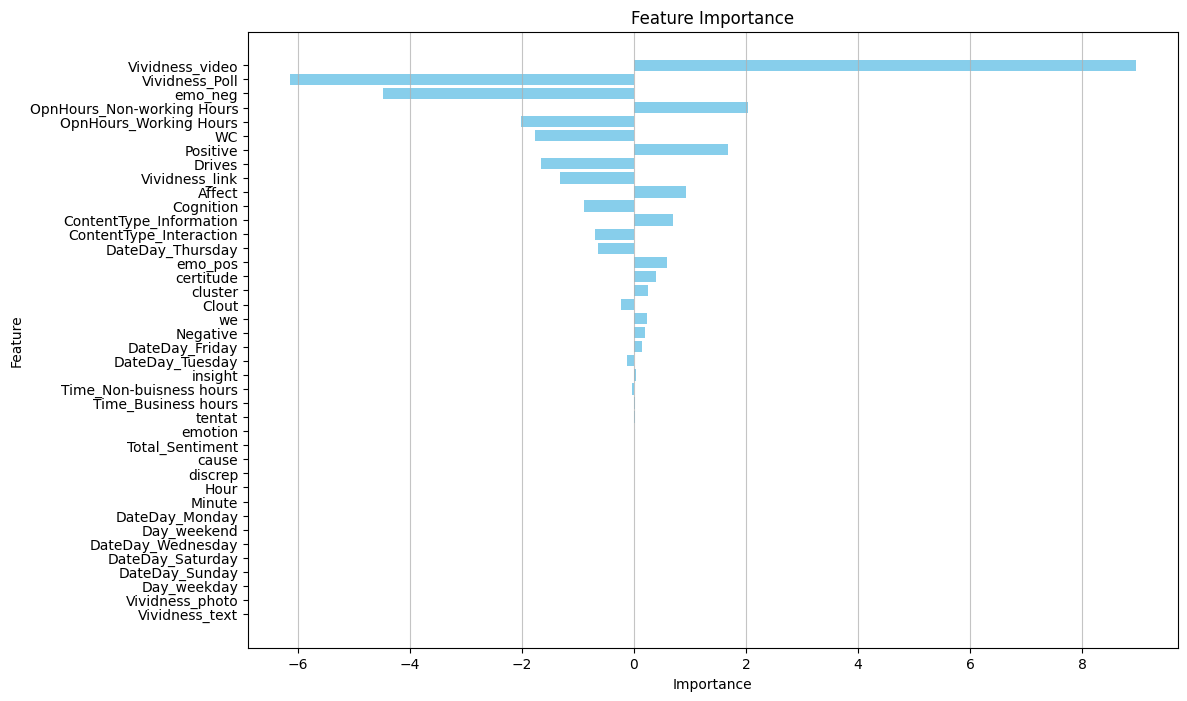

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import bootstrap

def calculate_confidence_interval(data, alpha=0.05):
    """Calculate confidence intervals using bootstrapping."""
    res = bootstrap((data,), np.mean, confidence_level=1-alpha, n_resamples=1000, method='percentile')
    return res.confidence_interval

def train_elastic_net_with_error_analysis_and_feature_importance(X, y, feature_names, outer_splits=5, inner_splits=3, random_state=42):
    # Outer cross-validation
    outer_cv = KFold(n_splits=outer_splits, shuffle=True, random_state=random_state)

    # Inner cross-validation for hyperparameter tuning
    inner_cv = KFold(n_splits=inner_splits, shuffle=True, random_state=random_state)

    # Define parameter grid for ElasticNet
    param_grid = {
        'alpha': [0.1, 1.0, 10.0],  # Regularization strength
        'l1_ratio': [0.1, 0.5, 0.9]  # Mix of L1 and L2 penalties
    }

    # ElasticNet model
    elastic_net = ElasticNet(max_iter=1000, random_state=random_state)

    # GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=elastic_net,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',  # Negative MSE as the scoring metric
        cv=inner_cv,
        n_jobs=-1  # Parallelize grid search
    )

    # Perform nested cross-validation
    nested_scores = cross_val_score(
        grid_search, X, y, cv=outer_cv, scoring='neg_mean_squared_error', n_jobs=-1
    )

    # Fit the final model using the entire dataset
    grid_search.fit(X, y)

    # Print results
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Score (Inner CV): {grid_search.best_score_}")
    print(f"Nested CV Mean Score: {np.mean(nested_scores)}")
    print(f"Nested CV Std Dev: {np.std(nested_scores)}")

    # Evaluate predictions and calculate errors
    y_pred = grid_search.predict(X)
    mse_error = mean_squared_error(y, y_pred)
    mae_error = mean_absolute_error(y, y_pred)
    r2_error = r2_score(y, y_pred)

    # Bootstrapping for confidence intervals
    errors = np.array([mse_error, mae_error, r2_error])
    mse_ci = calculate_confidence_interval(np.abs(y - y_pred)**2)
    mae_ci = calculate_confidence_interval(np.abs(y - y_pred))
    r2_ci = calculate_confidence_interval(np.array([r2_error] * len(y)))  # Single value repeated

    # Create a table of results
    results_df = pd.DataFrame({
        'Metric': ['MSE', 'MAE', 'R^2'],
        'Value': [mse_error, mae_error, r2_error],
        'Lower CI': [mse_ci.low, mae_ci.low, r2_ci.low],
        'Upper CI': [mse_ci.high, mae_ci.high, r2_ci.high]
    })

    print("\nError Metrics and Confidence Intervals:")
    print(results_df)

    # Feature importance plot
    best_model = grid_search.best_estimator_
    feature_importance = best_model.coef_

    # Plot feature importances
    plt.figure(figsize=(12, 8))
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    importance_df = importance_df.sort_values(by='Importance', key=abs, ascending=False)  # Sort by absolute importance
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
    plt.grid(axis='x', alpha=0.75)
    plt.show()

    return best_model, nested_scores, results_df

# Example usage
X = preprocessed_data  # Replace with your features
y = target_data  # Replace with your target
feature_names = X.columns  # Replace with the correct feature names if different

best_model, nested_cv_scores, error_metrics_df = train_elastic_net_with_error_analysis_and_feature_importance(X, y, feature_names)
